# Predicción de NBV 

En este notebook implementaremos un sistema para reconstrucción via NBV haciendo uso de la arquitectura autoencoder y MLP

* pedirá la dirección a la carpeta contenedora del objeto
* Creará un link simbolico para acceder a las texturas (verifica si no existe ya) y carpetas para almacenar la información obtenida durante el proceso: 
    - Nubes de puntos
    - RGB
    - Profundidad
* Despliega el objeto para verificar si es el que espera el usuario y debe confirmar si es correcto
* Genera una posición y orientación random (podría extraerla de Hintertoiser), importante conocer el bounding box para no colisionar con el objeto
* Inicia el proceso de reconstrucción
* Captura información y almacena 
* Crea grid de 31x31x31
* Procesamiento de IA
* Condición si la cumple repite o finaliza
* Reporte de métricas

## TODO: guarda y visualizar nube de puntos e imagen

In [1]:
import os
from symlink import symbolic_dir
import open3d as o3d
import octomap
import torch
from utils_o3d import Get_Pointcloud, Get_RGBD, Get_octree
from MLP import MLP
from utils import net_sample_output_nbv
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
if os.path.lexists("poses.npy") == False:
    from tesselation import hinter_sampling
    poses, _ = hinter_sampling(50, radius = 1)
    np.save("poses.npy", poses)
    print("teselando")
print("Ingresa la dirección a la carpeta contenedora del banco de datos")
direccion = input("Cúal es la dirección a la carpeta contenedora?:") # Dataset acces
print(list(filter(os.path.isdir, os.listdir(direccion))))
carpeta = input("A que carpeta quieres acceder?: ") #object folder
direccion_disco = '/mnt/6C24E28478939C77/Saulo/ProyectoPHD/'
dir_carpeta = direccion_disco + direccion + carpeta
if os.path.lexists(dir_carpeta + "/meshes/texture.png") == False:
    symbolic_dir(dir_carpeta)
    RGB = "/RGB"
    Depth = "/Depth"
    Point_cloud = "/Point_cloud"
    Octree = "/Octree"
    os.mkdir(dir_carpeta + RGB)
    os.mkdir(dir_carpeta + Depth)
    os.mkdir(dir_carpeta + Point_cloud)
    os.mkdir(dir_carpeta + Octree)
    #print("Cree link simbolico")
visualizar = input("Quieres visualizar el objeto? (presiona S en caso de sí):") 
if visualizar == 'S'  or  visualizar == 's' :
    mesh = o3d.io.read_triangle_mesh(dir_carpeta + '/meshes/model.obj', True) 
    o3d.visualization.draw_geometries([mesh])

global p_c

fov = 35
img_H = 100
img_W = 100
up = [0, 1, 0]
cent = [0.0,0.0,0.0]
#eye = [0.5,0.2,0.0] #Where the camera is
resolution = 0.01

## TODO: Aqui generamos la vista random
poses = np.load("poses.npy")
#random = np.random.randint(0,161, size= 10)
eye = poses
condicion = False
i = 0
#Cargamos los modelos de predicción de posición
model= MLP().cuda() 
#path_weights = '/position/weights_entrenamiento_MLP_11.pth' ## Modificar direccion de pesos
#model.load_state_dict(torch.load(path_weights))
device = torch.cuda.current_device()

#Inicializamos el octomap
resolution = 0.01 # resolucion del octree
octree = octomap.OcTree(resolution) # inicializamos el octree

#Cargamos malla
mesh = o3d.io.read_triangle_mesh(dir_carpeta + '/meshes/model.obj', True)
material = o3d.visualization.rendering.MaterialRecord() # Create material
material.albedo_img = o3d.io.read_image( dir_carpeta + '/meshes/texture.png') # Add texture
mesh.translate([0,0,0]) # translate to world CF origin
mesh.scale(2.0, center=(0,0,0))#center = mesh.get_center()) #Scale mesh
# Raycasting
mesh1 = o3d.t.geometry.TriangleMesh.from_legacy(mesh)
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(mesh1)
# render for RGBD images

render = o3d.visualization.rendering.OffscreenRenderer(width=img_W, height=img_H) #Linux only
render.scene.add_geometry('mesh', mesh, material)

print("Inicia el proceso de reconstrucción ...")
#while condicion == False:
for i in range(0,len(poses)):    

    # RGBD and pointcloud extraction
    Get_Pointcloud(scene, fov, cent, eye[i], up, img_W, img_H, dir_carpeta, i)
    Get_RGBD(render,  fov, cent, eye[i], up, dir_carpeta, i)
    #Occupancy grid
    occupancy_probs =  Get_octree(octree, dir_carpeta, i, eye[i])
    direccion_octree= bytes(dir_carpeta + "/Octree/octree_{}.ot".format(i), encoding='utf8')
    octree.writeBinary(direccion_octree)
    grid = np.reshape(occupancy_probs, (31,31,31))    
    ## Aqui evaluamos si esta completo el modelo en este punto
    ## De no estarlo, se consulta a la NN el NBV 
    torch_grid = torch.from_numpy(grid)
    #condicion = True
    #IA
    #output, _= net_sample_output_nbv(model, grid, device) 
    
    #Evaluacion
    # Esta completa la reconstrucción?
    # si condicion = False
    # continua
    # si condicion = True 
    # break 
    # Metricas 
print("Volví, tonotos!")

teselando
Ingresa la dirección a la carpeta contenedora del banco de datos


[]
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x3ea69620 (threading is enabled)
Inicia el proceso de reconstrucción ...
EGL(1.5)
OpenGL(4.1)
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos octree
estamos en el octree

terminamos

## Extras

In [3]:
from classification_nbv import showGrid, showGrid4
import numpy as np

<Figure size 640x480 with 0 Axes>

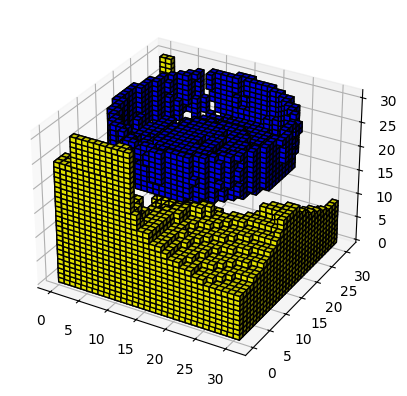

In [4]:
showGrid(occupancy_probs, "1.png")

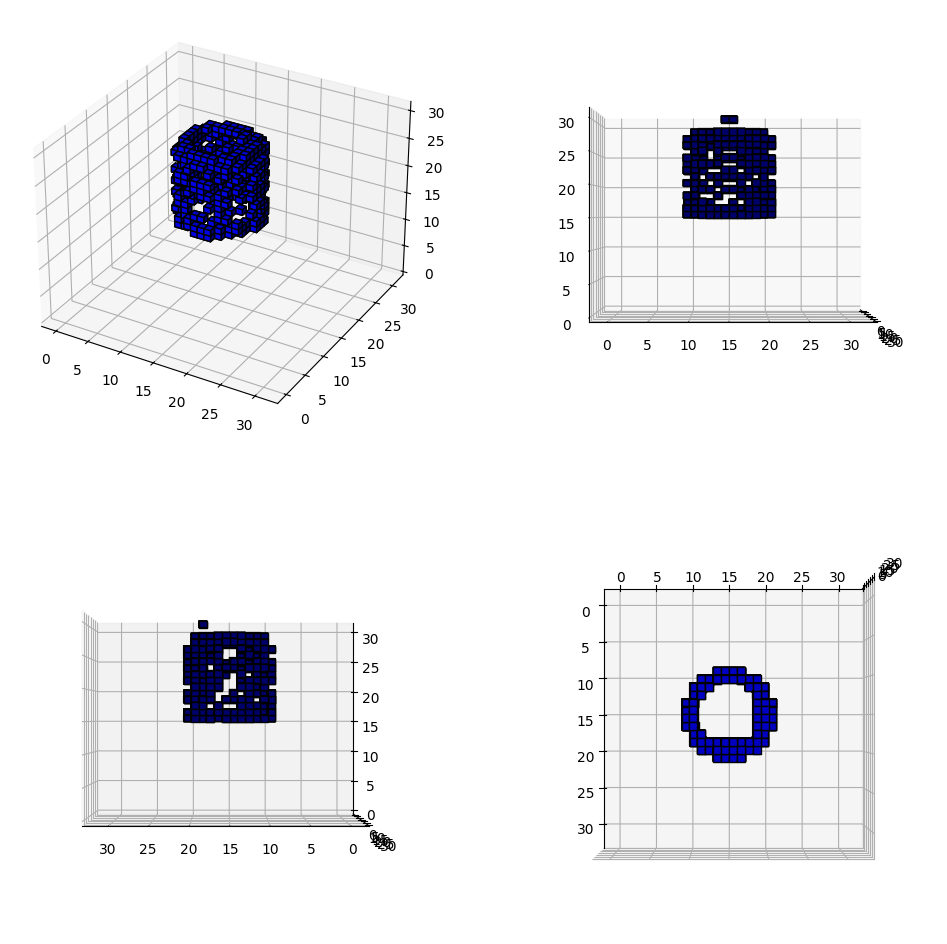

In [4]:
showGrid4(occupancy_probs)

In [8]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
nube = o3d.io.read_point_cloud("objetos/Point_cloud/cloud_41.pcd")

In [6]:
o3d.visualization.draw_geometries([nube])

In [ ]:
python3 download_collection.py -o "GoogleResearch" -c "Scanned Objects by Google Research"